# Get acces to google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installl pytorch in colab

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

# import packages 


In [0]:
import numpy as np

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler, DataLoader
from torch.autograd import Variable

import os

from time import time

import matplotlib.pyplot as plt
%matplotlib inline
    

# Data

### Transforming

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                               ])


### Download

In [0]:
train = datasets.MNIST('~/.pytorch/MNIST_data/', train=True, transform=transform, download=True)
test = datasets.MNIST('~/.pytorch/MNIST_data/', train=False, transform=transform, download=True)

### Split data

In [0]:
batch_size = 64
val_size = 0.2

train_size = len(train)
indices = list(range(train_size))
np.random.shuffle(indices)
split_size = int(val_size * train_size)

train_indices, val_indices = indices[split_size:], indices[:split_size]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

### Load data

In [0]:
train_loader = DataLoader(train, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
val_loader = DataLoader(train, batch_size=batch_size, sampler=val_sampler, pin_memory=True)
test_loader = DataLoader(test, batch_size=batch_size)

# Display Data Samples

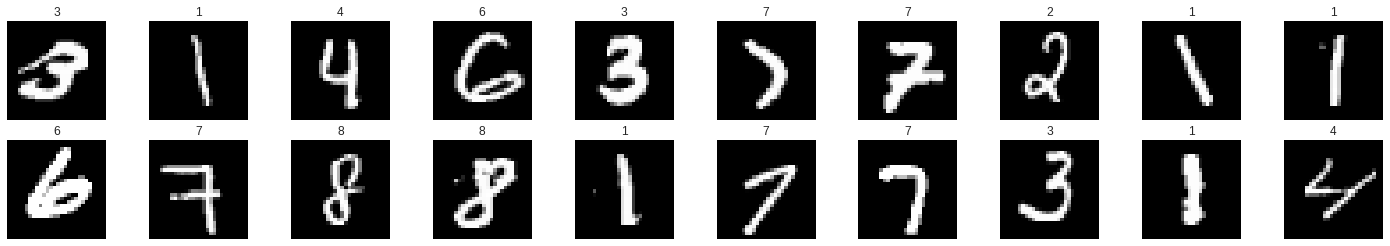

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  # print out the correct label for each image
  # .item() gets the value contained in a Tensor
  ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

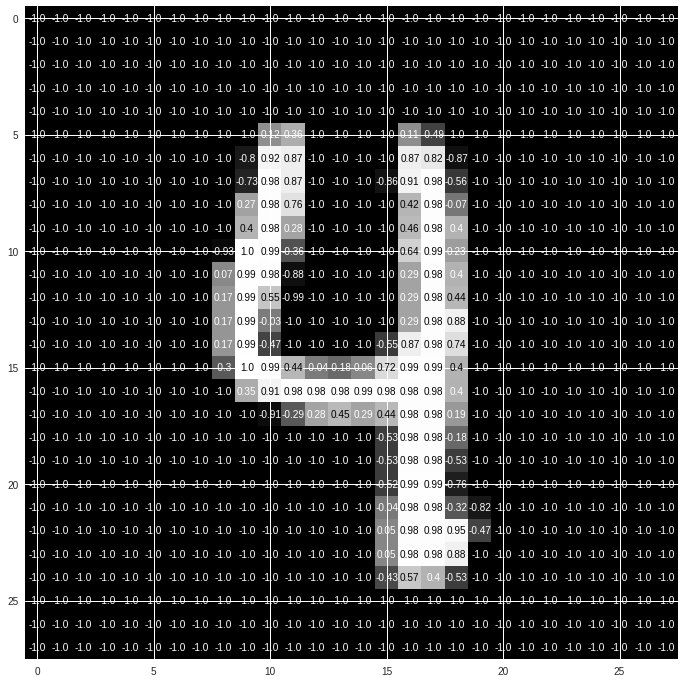

In [0]:
img = np.squeeze(images[2])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Neural Network

In [0]:
class NeuralNetwork(nn.Module):
  
  def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
    
    super().__init__()
    
    self.input_size = input_size
    
    
    
    self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
    
    for input, output in zip(hidden_layers[:-1], hidden_layers[1:]):
      self.hidden_layers.extend([nn.Linear(input, output)])
    
    self.output_layer = nn.Linear(hidden_layers[-1], output_size)
    
    
    
    
    self.relu = F.relu
    
    self.drop = nn.Dropout(p=drop_p)
    
  def forward(self,x):
    x = x.view(-1, self.input_size)
    for layer in self.hidden_layers:
      x = layer(x)
      x = self.relu(x)
      x = self.drop(x)
      
    x = self.output_layer(x)
    
    return x

In [0]:
input_size = images[0].shape[1] * images[0].shape[2]
output_size = 10
hidden_layers_size = [512, 128, 64, 32]
drop_p = 0.2
net = NeuralNetwork(input_size=input_size, output_size=output_size, hidden_layers=hidden_layers_size, drop_p=drop_p)
net

NeuralNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
  (drop): Dropout(p=0.2)
)

# Checkpoint saver

In [0]:
def save_checkpoint(model):
  
  return {'input_size': model.input_size,
          'output_size': model.output_layer.out_features,
          'hidden_layers': [each.out_features for each in model.hidden_layers],
          'state_dict': model.state_dict()}

In [0]:
checkpoint = save_checkpoint(net)

# Check for GPU

In [0]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    net.cuda()
      

CUDA is available!  Training on GPU ...


# Loss & Optimizer

In [0]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Train

In [0]:
def train(model, train_loader, val_loader, optimizer, loss_function, checkpoint, saving_path,n_epochs=30):
  
  train_losses = []
  train_accs = []
  
  val_losses = []
  val_accs = []

  min_val_loss = np.Inf

  model.train()      
  for i in range(1,n_epochs+1):
    s = time()
    train_loss = 0
    train_acc = 0
    for x,y in train_loader:
      if train_on_gpu:
        x, y = x.cuda(), y.cuda()
      optimizer.zero_grad()
      
      y_ = model.forward(x)
      
      loss = loss_function(y_,y)
      
      loss.backward()
      
      optimizer.step()
      
      train_loss += loss.item()
      
      ps = torch.exp(y_)
      top_p, top_class = ps.topk(1, dim=1)
      equals = top_class == y.view(*top_class.shape)
      train_acc += torch.mean(equals.type(torch.FloatTensor))
    
    
    else:
      val_loss = 0
      val_acc = 0
      with torch.no_grad():
        model.eval()
        
        for x,y in val_loader:
         
          if train_on_gpu:
            x, y = x.cuda(), y.cuda()
          y_ = model.forward(x)

          loss = loss_function(y_,y)
          
          val_loss += loss.item()
          
          ps = torch.exp(y_)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == y.view(*top_class.shape)
          
          val_acc += torch.mean(equals.type(torch.FloatTensor))
          
    train_loss /= len(train_loader)     
    train_acc /= len(train_loader)  
    
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    if min_val_loss > val_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_val_loss, val_loss))
        min_val_loss = val_loss
        checkpoint['state_dict'] = net.state_dict()
        torch.save(checkpoint, os.path.join('{}'.format(saving_path), 'checkpoint.pth'))
    print("Epoch: {}/{}.. ".format(i,n_epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Validation Loss: {:.3f}.. ".format(val_loss),
              "train Accuracy: {:.3f}".format(train_acc),
              "Validation Accuracy: {:.3f}".format(val_acc),
              "Delay: {:.2f} s".format((time()-s))
         )
      
      
  return train_losses, train_accs, val_losses, val_accs
    



In [0]:
train_losses, train_accs, val_losses, val_accs = train(model= net,train_loader=train_loader,val_loader=val_loader,n_epochs=30,optimizer=optimizer,loss_function=loss_function,checkpoint=checkpoint,saving_path='drive/My Drive/checkpoints')

Validation loss decreased (inf --> 2.065152).  Saving model ...
Epoch: 1/100..  Training Loss: 2.261..  Validation Loss: 2.065..  train Accuracy: 0.189 Validation Accuracy: 0.332 Delay: 12.99 s
Validation loss decreased (2.065152 --> 0.690364).  Saving model ...
Epoch: 2/100..  Training Loss: 1.136..  Validation Loss: 0.690..  train Accuracy: 0.642 Validation Accuracy: 0.789 Delay: 12.10 s
Validation loss decreased (0.690364 --> 0.484240).  Saving model ...
Epoch: 3/100..  Training Loss: 0.545..  Validation Loss: 0.484..  train Accuracy: 0.834 Validation Accuracy: 0.855 Delay: 12.13 s
Validation loss decreased (0.484240 --> 0.422337).  Saving model ...
Epoch: 4/100..  Training Loss: 0.426..  Validation Loss: 0.422..  train Accuracy: 0.875 Validation Accuracy: 0.875 Delay: 12.08 s
Validation loss decreased (0.422337 --> 0.324928).  Saving model ...
Epoch: 5/100..  Training Loss: 0.346..  Validation Loss: 0.325..  train Accuracy: 0.899 Validation Accuracy: 0.902 Delay: 12.08 s
Validation

# Train & Validation (loss,accuracy) graph

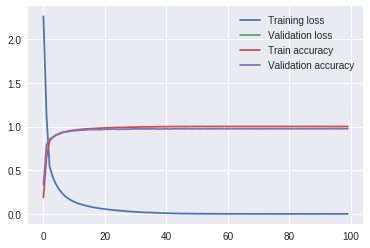

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.plot(train_accs, label='Train accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend(frameon=False)

# Load Model

In [0]:

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = NeuralNetwork(input_size=checkpoint['input_size'],
                             output_size=checkpoint['output_size'],
                             hidden_layers=checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model


In [0]:
net = load_checkpoint('drive/My Drive/checkpoints/checkpoint.pth')

# Test

In [0]:
def validation(model, test_loader, loss_function):
    test_acc = 0
    test_loss = 0
    model.eval()
    if torch.cuda.is_available():
      model.cuda()
    for x, y in test_loader:
      print(y)
      if torch.cuda.is_available():
        x,y = x.cuda(), y.cuda()

      else:
        x,y = x.float(), y.float()


      y_ = model.forward(x)
      test_loss += loss_function(y_, y).item()

      ps = torch.exp(y_)
      top_p, top_class = ps.topk(1, dim=1)
      equals = top_class == y.view(*top_class.shape) 
      test_acc += torch.mean(equals.type(torch.FloatTensor))
        
    test_acc /= len(test_loader)
    test_loss /= len(test_loader)
    
    return test_loss, test_acc


In [0]:
test_loss, test_accuracy = validation(net,test_loader,loss_function)

In [0]:
test_accuracy

tensor(0.9724)